# Importing libraries and loading data

In [22]:
%pip install python-metar

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from metar import Metar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime, timedelta
from statistics import mode
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [24]:
bimtra_df = pd.read_csv('data/bimtra_df.csv')
esperas_df = pd.read_csv('data/esperas_df.csv')
metaf_df = pd.read_csv('data/metaf_df.csv')
metar_df = pd.read_csv('data/metar_df.csv')
tc_prev_df = pd.read_csv('data/tc-prev_df.csv')
tc_real_df = pd.read_csv('data/tc-real_df.csv')
test_data = pd.read_csv('data/idsc_test.csv')

cat_62 = pd.read_csv('data/cat-62_df.csv')

In [25]:
cat_62['flightid'].value_counts()

183be2facf64b3b747f55fcdbfc995fc    950
57005fa176e59c4e5f79bb261065a0a8    712
0eda906927a7d129cfbf00810f374ad0    690
17c9c85817cf96873984072bf64b7410    622
2ee341b313b0d2904f1b6d30731cbd71    622
                                   ... 
be3f13ffbeb37c072f71ecb8e172e6d7      1
1effbeae39d791b77acbe503c6df3856      1
04a1d2f03e1d7ecd8d1629da6563a004      1
78502810f6f730deae791aa723da505c      1
163f8cc4a6eae9bd95b8c3c063ab6b21      1
Name: flightid, Length: 9010, dtype: int64

In [26]:
cat_62

,flightid,lat,lon,flightlevel,speed,dt_radar
0,b6f0f8308bec35b30533f84c72dac496,-0.505849,-0.884547,80.0,122.0,1654976586000
1,b6f0f8308bec35b30533f84c72dac496,-0.511227,-0.885964,80.0,114.0,1654977185000
2,b6f0f8308bec35b30533f84c72dac496,-0.512399,-0.886286,80.0,122.0,1654977306000
3,b6f0f8308bec35b30533f84c72dac496,-0.514589,-0.886866,77.0,117.0,1654977544000
4,b6f0f8308bec35b30533f84c72dac496,-0.497432,-0.882033,80.0,117.0,1654975686000
...,...,...,...,...,...,...
1122952,1ab0e0a1942895a7d531e0bfe66ac5b7,-0.411464,-0.814929,34.0,127.0,1654178642000
1122953,1ab0e0a1942895a7d531e0bfe66ac5b7,-0.408610,-0.810081,48.0,187.0,1654177746000
1122954,1ab0e0a1942895a7d531e0bfe66ac5b7,-0.408479,-0.808731,75.0,303.0,1654177802000
1122955,1ab0e0a1942895a7d531e0bfe66ac5b7,-0.412352,-0.814311,23.0,121.0,1654178762000


# Exploratory Analysis

In [27]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [28]:
test_data.snapshot_radar.sample(1)

94    MULTIPOINT ((-0.8933940196863707 -0.5148791086...
Name: snapshot_radar, dtype: object

In [29]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [30]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [31]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [32]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (300347, 5)
esperas_df: (99936, 3)
metaf_df: (43938, 3)
metar_df: (106744, 3)
tc_prev_df: (99936, 3)
tc_real_df: (33431, 4)


# Pre Processing

In [33]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [34]:
bimtra_df['solution'].describe()

count    300347.000000
mean       4621.902416
std        2505.949714
min      -84219.000000
25%        2963.000000
50%        4066.000000
75%        5364.000000
max       73821.000000
Name: solution, dtype: float64

In [35]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
230497,1e23b2154c05b8d0618ccc4b4ae73ddb,SBGR,SBCT,1678318487000,1678234268000,-84219
146666,db9903af1027400c42c54ee042be4fa3,SBPA,SBRJ,1669852784000,1669768816000,-83968
184372,90c4f6e70efbc6d27e4c91d74fca8e32,SBSP,SBRJ,1673652586000,1673568759000,-83827
212056,20d4548f0262ba5f7858a34932f47542,SBGR,SBCT,1676418137000,1676334378000,-83759
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541


/Users/tommygoto/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='solution'>

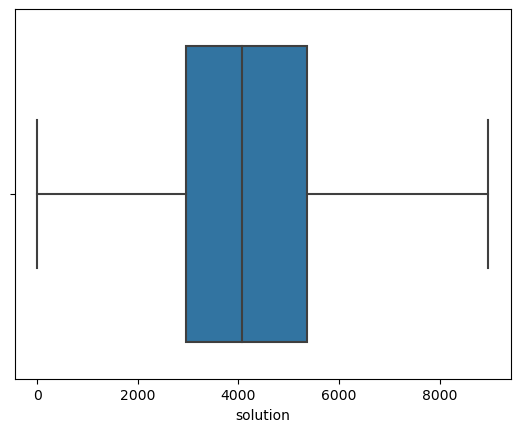

In [36]:
sns.boxplot(bimtra_df.query('solution > 0')['solution'], showfliers=False)

In [37]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) & (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [38]:
bimtra_df['solution'].describe()

count    298444.000000
mean       4637.336649
std        2179.087618
min        2000.000000
25%        2970.000000
50%        4079.000000
75%        5360.000000
max       11958.000000
Name: solution, dtype: float64

<AxesSubplot:xlabel='solution', ylabel='Count'>

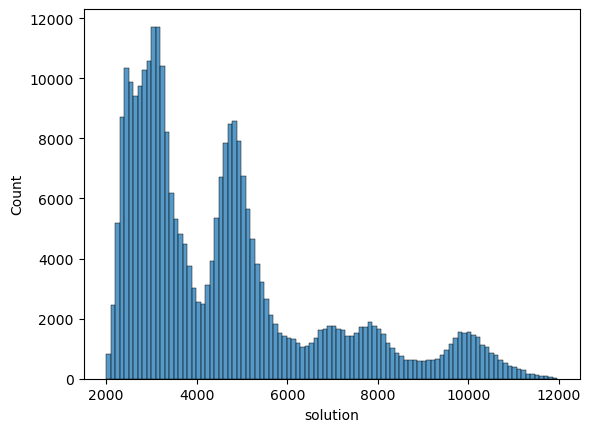

In [39]:
sns.histplot(bimtra_df['solution'], bins=100)

In [40]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [41]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [42]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [43]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(33431, 4)

In [44]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [45]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [46]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (298444, 7)
esperas_df: (99936, 5)
metaf_df: (43938, 3)
metar_df: (106744, 3)
tc_prev_df: (99936, 3)
tc_real_df: (33431, 4)


In [47]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [48]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [49]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [50]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
169315,bddb339e9144c9e13d64832c304cf4c9,SBRF,SBSP,2022-12-05 17:17:40,2022-12-05 20:36:58,11958,2022-12-05 17:00:00,2,SBSP,2022-12-05 17:00:00,0,SBSP,2022-12-05 17:00:00,NaN,NaN,NaN,NaT
51605,05770861785eba2d722d2d9f34d52df6,SBRF,SBGR,2022-07-29 14:16:37,2022-07-29 17:35:45,11948,2022-07-29 14:00:00,0,SBGR,2022-07-29 14:00:00,1,SBGR,2022-07-29 14:00:00,27L,12,SBGR,2022-07-29 14:20:38
92106,20662512b779c93b9b4de078c9f03294,SBRF,SBSP,2022-09-12 11:58:02,2022-09-12 15:17:07,11945,2022-09-12 11:00:00,0,SBSP,2022-09-12 11:00:00,0,SBSP,2022-09-12 11:00:00,17R,15,SBSP,2022-09-12 11:05:51
57039,e63b19dfc6d8bd1a7d777e7de410e09d,SBRF,SBSP,2022-08-04 20:09:39,2022-08-04 23:28:38,11939,2022-08-04 20:00:00,0,SBSP,2022-08-04 20:00:00,1,SBSP,2022-08-04 20:00:00,35L,30,SBSP,2022-08-04 20:14:29
266544,880a09d9da267bf38e8850e4fcb84bad,SBSV,SBSP,2023-03-14 18:01:44,2023-03-14 21:20:41,11937,2023-03-14 18:00:00,11,SBSP,2023-03-14 18:00:00,0,SBSP,2023-03-14 18:00:00,NaN,NaN,NaN,NaT
265971,880a09d9da267bf38e8850e4fcb84bad,SBSV,SBSP,2023-03-14 18:01:44,2023-03-14 21:20:41,11937,2023-03-14 18:00:00,11,SBSP,2023-03-14 18:00:00,0,SBSP,2023-03-14 18:00:00,NaN,NaN,NaN,NaT
163759,b09da2fabf3c26565b2b7a78f0850629,SBRF,SBKP,2022-11-29 18:15:56,2022-11-29 21:34:53,11937,2022-11-29 18:00:00,2,SBKP,2022-11-29 18:00:00,1,SBKP,2022-11-29 18:00:00,NaN,NaN,NaN,NaT
125876,923fde3bfc0b36c642ee0748986b7b89,SBRF,SBKP,2022-10-20 18:42:13,2022-10-20 22:01:10,11937,2022-10-20 18:00:00,0,SBKP,2022-10-20 18:00:00,0,SBKP,2022-10-20 18:00:00,33,19,SBKP,2022-10-20 18:34:09
199840,377584734a9ad23d6e315c1f410fb542,SBRF,SBRJ,2023-01-05 20:33:45,2023-01-05 23:52:40,11935,2023-01-05 20:00:00,0,SBRJ,2023-01-05 20:00:00,0,SBRJ,2023-01-05 20:00:00,NaN,NaN,NaN,NaT
127232,565adbb72c59b5f882b3218e7c2c4695,SBRF,SBSP,2022-10-21 19:23:45,2022-10-21 22:42:39,11934,2022-10-21 19:00:00,0,SBSP,2022-10-21 19:00:00,0,SBSP,2022-10-21 19:00:00,35L,17,SBSP,2022-10-21 19:59:07


In [51]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
55267,ea96e148996e2d5ba71463314b7e3e63,SBGR,SBCF,2022-08-02 11:30:27,2022-08-02 12:23:44,3197,2022-08-02 11:00:00,0,SBCF,2022-08-02 11:00:00,0,SBCF,2022-08-02 11:00:00,NaN,NaN,NaN,NaT
295283,ef310a867bd063abd8a51efab9953bce,SBSP,SBBR,2023-04-09 12:24:50,2023-04-09 13:53:42,5332,2023-04-09 12:00:00,0,SBBR,2023-04-09 12:00:00,0,SBBR,2023-04-09 12:00:00,NaN,NaN,NaN,NaT
80713,801bbf660c419288bac52ae4fcd71217,SBFL,SBKP,2022-08-30 14:27:51,2022-08-30 15:28:56,3665,2022-08-30 14:00:00,0,SBKP,2022-08-30 14:00:00,0,SBKP,2022-08-30 14:00:00,NaN,NaN,NaN,NaT
63540,08db086a744c3ca4250be74e52e8b46b,SBSP,SBRJ,2022-08-11 19:25:48,2022-08-11 20:01:07,2119,2022-08-11 19:00:00,1,SBRJ,2022-08-11 19:00:00,0,SBRJ,2022-08-11 19:00:00,02R,20L,SBRJ,2022-08-11 19:01:12
53692,97601171fb4486de901abec77ca4e57a,SBSP,SBRJ,2022-07-31 14:28:23,2022-07-31 15:04:36,2173,2022-07-31 14:00:00,0,SBRJ,2022-07-31 14:00:00,0,SBRJ,2022-07-31 14:00:00,NaN,NaN,NaN,NaT
183137,6a96cfbe5fda9ffde0d78b6beee81728,SBCF,SBGR,2022-12-19 11:47:51,2022-12-19 12:40:09,3138,2022-12-19 11:00:00,0,SBGR,2022-12-19 11:00:00,0,SBGR,2022-12-19 11:00:00,NaN,NaN,NaN,NaT
104269,b13cc6fa1160a6c807c4e23971929024,SBKP,SBPA,2022-09-26 21:14:22,2022-09-26 22:34:03,4781,2022-09-26 21:00:00,0,SBPA,2022-09-26 21:00:00,0,SBPA,2022-09-26 21:00:00,NaN,NaN,NaN,NaT
316277,7c4cd19cb0ba855142e78dcdc769ca6b,SBFL,SBKP,2023-04-21 21:11:23,2023-04-21 22:06:46,3323,2023-04-21 21:00:00,0,SBKP,2023-04-21 21:00:00,0,SBKP,2023-04-21 21:00:00,15,18,SBKP,2023-04-21 21:01:38
16009,7bdfe367795106c5029cccd825f5091b,SBRJ,SBFL,2022-06-20 00:28:17,2022-06-20 01:48:51,4834,2022-06-20 00:00:00,0,SBFL,2022-06-20 00:00:00,0,SBFL,2022-06-20 00:00:00,NaN,NaN,NaN,NaT
238975,3a6f98ff507d5c16608dd29b8287a857,SBSP,SBPA,2023-02-14 19:51:44,2023-02-14 21:11:10,4766,2023-02-14 19:00:00,0,SBPA,2023-02-14 19:00:00,0,SBPA,2023-02-14 19:00:00,NaN,NaN,NaN,NaT


(338015, 17)

In [52]:
train_data.isna().sum() 

flightid                 0
origem                   0
destino                  0
dt_dep                   0
dt_arr                   0
solution                 0
hora_ref                 0
esperas                  0
aero_esperas             0
hora_esperas             0
troca                    0
aero_tcp                 0
hora_tcp                 0
nova_cabeceira      228680
antiga_cabeceira    228680
aero_tcr            228680
hora_tcr            228680
dtype: int64

In [53]:
train_data.shape

(338015, 17)

In [54]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [55]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [56]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [57]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [58]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [59]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [60]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
                            ...                        
95    METAF SBGR 192300Z  11006KT 9000       FEW019 ...
96    METAF SBKP 312000Z  23006KT 9999       OVC022 ...
97    METAF SBRJ 201600Z  10003KT 9999       FEW033 ...
98    METAF SBSP 311200Z 07006KT 6000  - RA  OVC026 ...
99      METAF SBCT 201400Z 01002KT CAVOK 19/08 Q1020=\n
Name: metaf, Length: 100, dtype: object

In [61]:
test_data.metaf = test_data.metaf.fillna('')

In [62]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [63]:
metaf_df.shape

(43938, 3)

In [64]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [65]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [66]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
19917,2022-11-01 23:00:00,METAR SBGR 012300Z 14012KT 5000 BR OVC033...,SBGR,14.0,12.0,140.0,5000.0,12.0,1020.0
28873,2023-01-01 17:00:00,METAR SBKP 011700Z 28004KT CAVOK 30/17 Q1012,SBKP,30.0,17.0,280.0,10000.0,4.0,1012.0
33719,2023-04-28 23:00:00,METAR SBPA 282300Z 09009KT CAVOK 21/12 Q1017,SBPA,21.0,12.0,90.0,10000.0,9.0,1017.0
9028,2022-06-03 14:00:00,METAR SBGL 031400Z 25004KT 8000 OVC033 ...,SBGL,22.0,19.0,250.0,8000.0,4.0,1019.0
24306,2022-06-07 19:00:00,METAR SBKP 071900Z 30008KT CAVOK 28/09 Q1011,SBKP,28.0,9.0,300.0,10000.0,8.0,1011.0


In [67]:
metaf_df.shape

(43938, 9)

In [68]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [69]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(106744, 18)

In [70]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [71]:
train_data.shape

(338015, 17)

In [72]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [73]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

In [74]:
le = LabelEncoder()

cat_columns = ['origem', 'destino', 'aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.fit_transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,SBKP,SBRJ,SBRJ,SBRJ,NaN
1,SBGR,SBRJ,SBRJ,SBRJ,NaN
2,SBBR,SBRJ,SBRJ,SBRJ,NaN
3,SBKP,SBCF,SBCF,SBCF,NaN
4,SBCF,SBFL,SBFL,SBFL,NaN


In [75]:
train_data[cat_columns].head()

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,6,9,9,9,12
1,5,9,9,9,12
2,0,9,9,9,12
3,6,1,1,1,12
4,1,3,3,3,12


In [76]:
train_data['rota'], test_data['rota'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
le.fit(train_data['rota'])
train_data['rota']= le.transform(train_data['rota'])
test_data['rota']= le.transform(test_data['rota'])

display(train_data['rota'].head())


0    66
1    62
2    10
3    18
4    15
Name: rota, dtype: int64

In [77]:
train_data['rota'].unique()

array([66, 62, 10, 18, 15, 24, 21, 29, 60, 68, 64, 19,  7,  6,  0,  5, 25,
        9, 61, 30, 69,  1, 31, 12, 44, 35, 17, 38, 51, 39,  2, 20,  3, 53,
       49,  8, 54, 23, 43, 65, 13, 14, 36, 48, 47, 42,  4, 45, 40, 56, 37,
       26, 28, 16, 58, 55, 63, 57, 32, 11, 33, 46, 41, 27, 34, 22, 67, 52,
       59, 50])

In [78]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,...,pressure_real,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,rota
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,...,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,...,1018.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,...,1021.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15


In [79]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,rota
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,11,...,None,None,None,None,0,0,0,0,0,36
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,9,...,330.0,10000.0,4.0,1020.0,0,0,0,0,0,51
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,5,...,40.0,10000.0,3.0,1021.0,0,0,0,0,0,17
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,10,...,150.0,10000.0,10.0,1019.0,0,0,0,0,0,25
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,6,...,80.0,10000.0,8.0,1019.0,0,0,0,0,0,18


In [80]:
np.count_nonzero(train_data.rota.unique())

69

In [81]:
train_data['solution'].describe()

count    338017.000000
mean       4684.519006
std        2150.353845
min        2000.000000
25%        3004.000000
50%        4222.000000
75%        5553.000000
max       11958.000000
Name: solution, dtype: float64

In [82]:
train_data.shape

(338017, 34)

In [83]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [84]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [85]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [86]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [87]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [88]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338017 entries, 0 to 338016
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   flightid             338017 non-null  object 
 1   origem               338017 non-null  int64  
 2   destino              338017 non-null  int64  
 3   dt_dep               338017 non-null  int64  
 4   solution             338017 non-null  int64  
 5   esperas              338017 non-null  int64  
 6   aero_esperas         338017 non-null  int64  
 7   troca                338017 non-null  int64  
 8   aero_tcp             338017 non-null  int64  
 9   aero_tcr             338017 non-null  int64  
 10  temperature_real     338017 non-null  float64
 11  dew_point_real       338017 non-null  float64
 12  wind_direction_real  338017 non-null  float64
 13  visibility_real      338017 non-null  float64
 14  wind_speed_real      338017 non-null  float64
 15  pressure_real    

In [89]:
scaler = StandardScaler()

# Modeling

In [90]:
train_data.shape

(338017, 23)

In [91]:
features = train_data.columns
features = features.drop(['flightid', 'solution'])
# train_data[features] = scaler.fit_transform(train_data[features])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

In [92]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

# model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# model2.fit(X_train, y_train)
# y_pred = model2.predict(X_test)
# y_pred = np.round_(y_pred)
# print(y_pred)
# print(f'Random Forest Regressor MSE: {mean_squared_error(y_test, y_pred)}')

model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)
print(y_pred)
print(f'XGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')

[3389. 6636. 3293. ... 4988. 4041. 2968.]
XGBoost Regressor MSE: 109931.30297023845


# Submission

In [93]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model3 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)